In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

adc.json  drive  sample_data


In [3]:
import os
os.chdir("/content/drive/DeepLearning/Applications/Balik")
!pwd

/content/drive/DeepLearning/Applications/Balik


In [4]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax

import sys
sys.path.append('..')
import Functions as fn

In [5]:
x_train = fn.np.load('VeriSetleri/x_train.npy')
y_train = fn.np.load('VeriSetleri/y_train.npy')
x_val = fn.np.load('VeriSetleri/x_val.npy')
y_val = fn.np.load('VeriSetleri/y_val.npy')
x_test = fn.np.load('VeriSetleri/x_test.npy')
y_test = fn.np.load('VeriSetleri/y_test.npy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 256)       295168    
                                                        

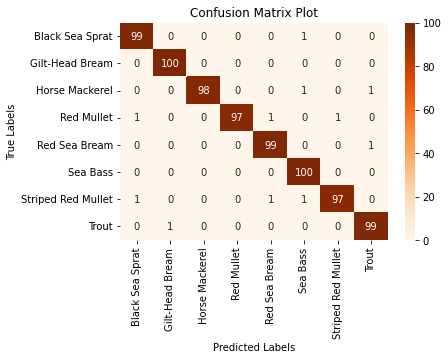

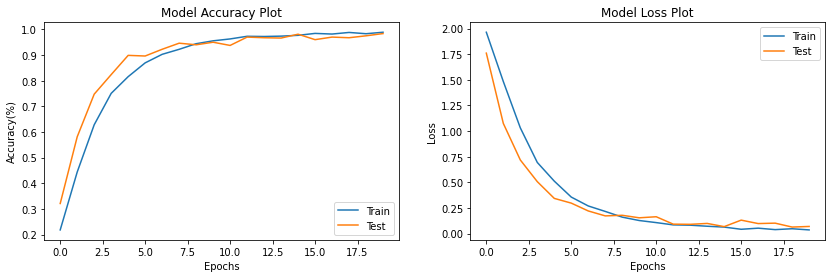

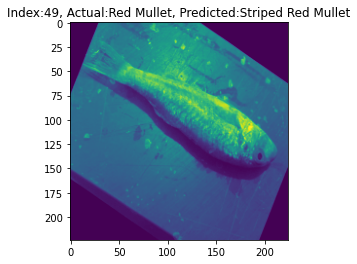

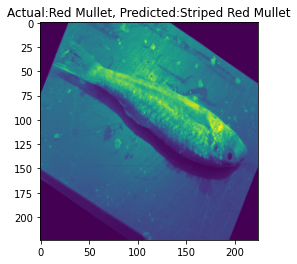

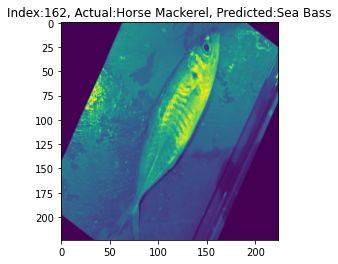

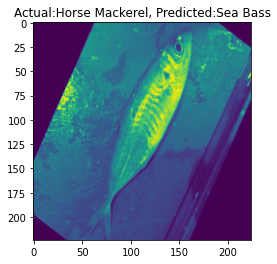

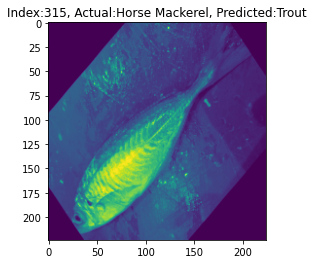

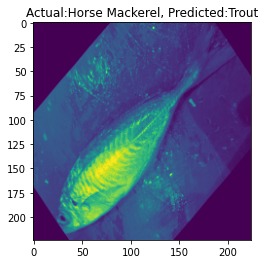

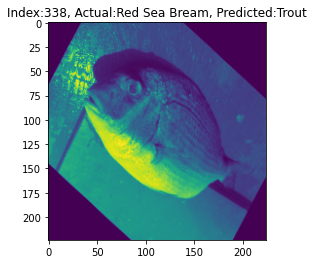

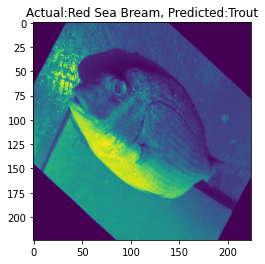

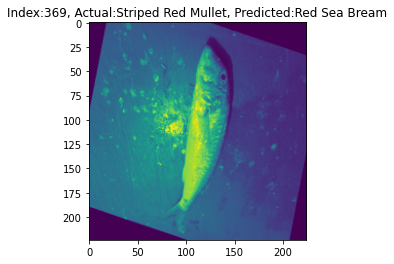

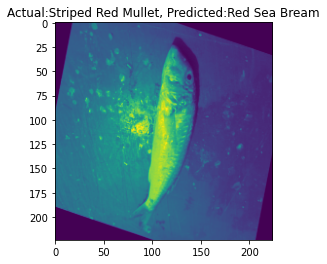

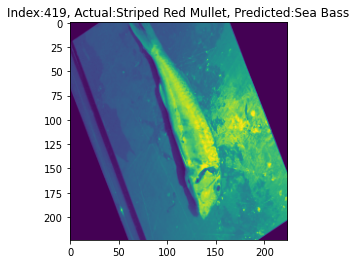

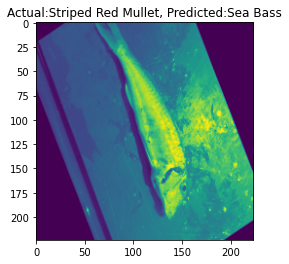

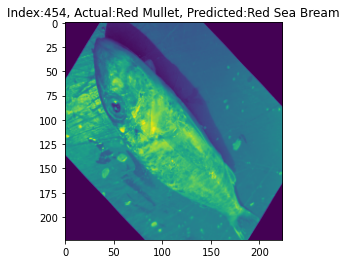

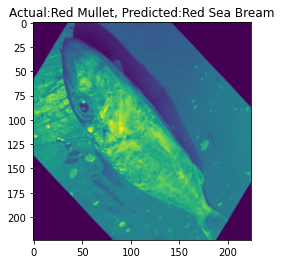

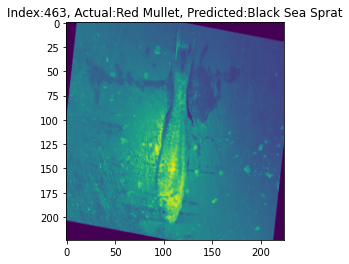

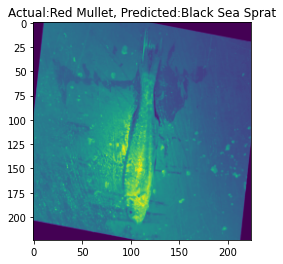

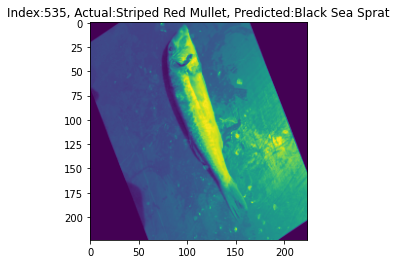

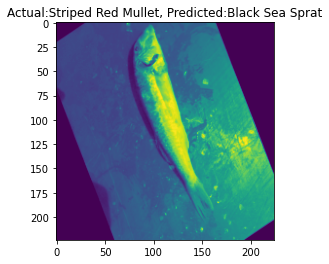

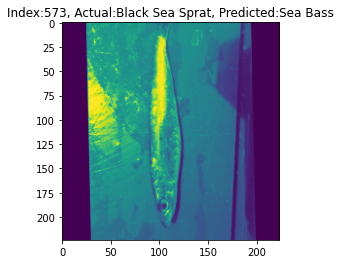

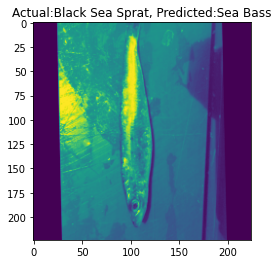

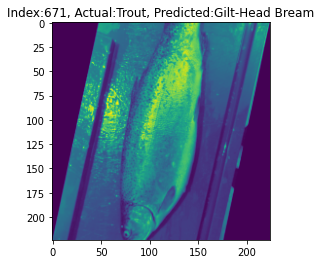

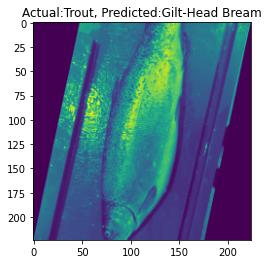

In [7]:
fn.keras.backend.clear_session()

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(fn.en, fn.boy, fn.kanal)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1024, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(fn.etiketSayisi, activation='softmax'))

model.summary()

model.compile(loss=fn.keras.losses.categorical_crossentropy,
              optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy'])
    
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save('BalikModel.h5')

score = model.evaluate(x_val, y_val, verbose=0)
print('Test Loss/Kayıp:', score[0])
print('Test Accuracy/Doğruluk:', score[1])


#Grafiklendirme
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
y_true = fn.np.argmax(y_val, axis=1)
#y_pred = model.predict_classes(x_val)
predict_x = model.predict(x_val)
y_pred = fn.np.argmax(predict_x, axis=1)

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
classification_report = classification_report(y_true, y_pred)
print(classification_report)

import seaborn as sns
import pandas as pd
classes = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Striped Red Mullet', 'Trout']
cf_matrix_df = pd.DataFrame(cf_matrix,
                            index = classes,
                            columns = classes)
sns.heatmap(cf_matrix_df, annot=True, fmt="d", cmap=plt.cm.Oranges)
plt.title('Confusion Matrix Plot')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


plt.figure(figsize=(14., 4.))
plt.subplots_adjust(hspace=0.4)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Plot')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()
#Grafiklendirme Son


for i in range (x_val.shape[0]):
    if y_true[i] != y_pred[i]:
        for j in range (len(classes)):
            if y_true[i] == j:
                yt = classes[j]
            if y_pred[i] == j:
                yp = classes[j]
        title = 'Index:' + str(i) + ', Actual:' + str(yt) + ', Predicted:' + str(yp)
        plt.title(title)
        plt.imshow(fn.np.squeeze(x_val[i]))
        plt.show()
        title = 'Actual:' + yt + ', Predicted:' + yp
        plt.title(title)
        plt.imshow(fn.np.squeeze(x_val[i]))
        plt.show()
fn.keras.backend.clear_session()